# Xception

### Part 1 - Building the CNN

#### Importing the Tensorflow libraries and packages

In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]
Pandas 1.4.3
Scikit-Learn 1.1.1
GPU is available


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

import os

##  Xception

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.applications import Xception

conv_model = Xception(include_top=False, weights='imagenet',input_shape=(150,150,3))

conv_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [4]:
import matplotlib.pyplot as plt
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def generators(shape): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    path_dir = '../../dataset/train'
    parth_dir_test = '../../dataset/test'

    datagen = ImageDataGenerator(
                    rescale=1./255,
                    #preprocessing_function=tensorflow.keras.applications.xception.preprocess_input,
                    validation_split = 0.2)

    train_dataset = datagen.flow_from_directory(
        path_dir,
        target_size=(150,150),
        shuffle=True,
        subset='training',
        batch_size = 64,
        seed = 11,
        class_mode = 'binary'
    )
    
    val_dataset = datagen.flow_from_directory(
        path_dir,
        target_size=(150,150),
        subset='validation',
        batch_size = 64,
        seed = 11,
        class_mode = 'binary'
    )

    test_dataset = datagen.flow_from_directory(parth_dir_test,
                                        target_size= (150,150),
                                        batch_size = 64,
                                        seed = 11,
                                        class_mode = 'binary',
                                        shuffle=False)
    return train_dataset, val_dataset, test_dataset

In [6]:
train_dataset, val_dataset, test_dataset = generators((150,150))

Found 2202 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 688 images belonging to 2 classes.


In [7]:
train_dataset.class_indices

{'nonviolence': 0, 'violence': 1}

In [8]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(16, activation='relu')(x)
x = keras.layers.Dropout(0.30)(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.30)(x)

# final softmax layer
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

block14_sepconv2_act (Activatio (None, 5, 5, 2048)   0           block14_sepconv2_bn[0][0]        
__________________________________________________________________________________________________
flatten (Flatten)               (None, 51200)        0           block14_sepconv2_act[0][0]       
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           819216      flatten[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 16)           0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dropout[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [9]:
for layer in conv_model.layers:
    layer.trainable = False

In [10]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [11]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.RMSprop(lr=0.001),
                  metrics=['acc'])

C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime

#rm -rf /logs/

es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_xception.h5', monitor='val_loss', mode='min', save_best_only=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Create a TensorBoard callback
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    callbacks = [tensorboard_callback,es,mc,reduceLR],
    epochs=40
)

C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/40
35/35 [==============================] - 23s 416ms/step - loss: 0.7451 - acc: 0.5790 - val_loss: 0.5380 - val_acc: 0.8218
Epoch 2/40
35/35 [==============================] - 8s 226ms/step - loss: 0.5723 - acc: 0.6776 - val_loss: 0.3638 - val_acc: 0.8364
Epoch 3/40
35/35 [==============================] - 8s 225ms/step - loss: 0.5323 - acc: 0.6866 - val_loss: 0.5316 - val_acc: 0.7691
Epoch 4/40
35/35 [==============================] - 9s 254ms/step - loss: 0.4796 - acc: 0.7139 - val_loss: 0.3172 - val_acc: 0.8418
Epoch 5/40
35/35 [==============================] - 8s 239ms/step - loss: 0.4788 - acc: 0.7284 - val_loss: 0.3602 - val_acc: 0.7982
Epoch 6/40
35/35 [==============================] - 8s 232ms/step - loss: 0.4637 - acc: 0.7507 - val_loss: 0.4392 - val_acc: 0.7800
Epoch 7/40
35/35 [==============================] - 8s 231ms/step - loss: 0.4403 - acc: 0.7480 - val_loss: 0.3658 - val_acc: 0.8255
Epoch 8/40
35/35 [==============================] - 8s 227ms/step - loss: 0

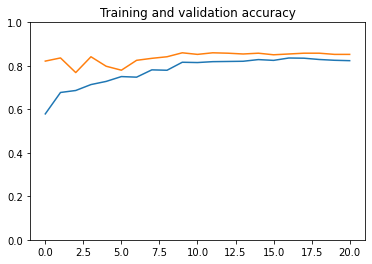

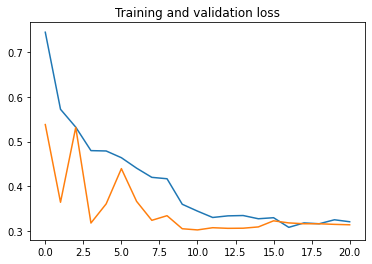

In [14]:
plot_history(history, yrange=(0,1))

In [22]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 14548), started 0:00:09 ago. (Use '!kill 14548' to kill it.)

In [16]:
full_model.load_weights('best_xception.h5')

In [17]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [18]:
score = full_model.evaluate(test_dataset, verbose=0)

print('Test Loss', score[0])
print('Test accuracy', score[1])

Test Loss 0.30034139752388
Test accuracy 0.8633720874786377


In [19]:
#Overfitting -> Your training accuracy will be higher than the accuracy on the validation/test set

#Overfitting indicates that your model is too complex for the problem that it is solving,
#filters in the case of Convolutional Neural Networks, and layers in the case of overall Deep Learning Models

#How do you know if your model is underfitting? Your model is underfitting if the accuracy on the validation set 
#is higher than the accuracy on the training set. Additionally, 
#if the whole model performs bad this is also called underfitting.

#https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d

In [20]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

yhat_classes = full_model.predict(test_dataset, verbose=0)
yhat_classes = yhat_classes[:, 0]

print(classification_report(test_dataset.classes,yhat_classes.round()))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       344
           1       0.84      0.90      0.87       344

    accuracy                           0.86       688
   macro avg       0.87      0.86      0.86       688
weighted avg       0.87      0.86      0.86       688

